<a href="https://colab.research.google.com/github/erkankaplan/GithupDeneme/blob/master/DCGAN_RESNET50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np


import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
# Metrics
from tensorflow.keras.metrics import *

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os

# Dosya yollarını belirle
benign_path = '/content/drive/MyDrive/Colab Notebooks/benign'
malignant_path = '/content/drive/MyDrive/Colab Notebooks/malignant'
normal_path = '/content/drive/MyDrive/Colab Notebooks/normal'

# Dosyaları listeleyin (örneğin, resim dosyaları)
benign_files = os.listdir(benign_path)
malignant_files = os.listdir(malignant_path)
normal_files = os.listdir(normal_path)

print("Benign dosyaları:", benign_files)
print("Malignant dosyaları:", malignant_files)
print("Normal dosyaları:", normal_files)

Benign dosyaları: ['benign (100)_mask_1.png', 'benign (1)_mask.png', 'benign (1).png', 'benign (103)_mask.png', 'benign (104).png', 'benign (105).png', 'benign (102).png', 'benign (103).png', 'benign (101)_mask.png', 'benign (104)_mask.png', 'benign (101).png', 'benign (10).png', 'benign (100).png', 'benign (100)_mask.png', 'benign (102)_mask.png', 'benign (105)_mask.png', 'benign (10)_mask.png', 'benign (117).png', 'benign (107).png', 'benign (106)_mask.png', 'benign (107)_mask.png', 'benign (108).png', 'benign (115)_mask.png', 'benign (108)_mask.png', 'benign (106).png', 'benign (109)_mask.png', 'benign (110)_mask.png', 'benign (11)_mask.png', 'benign (116)_mask.png', 'benign (113).png', 'benign (115).png', 'benign (114)_mask.png', 'benign (113)_mask.png', 'benign (111).png', 'benign (109).png', 'benign (116).png', 'benign (112).png', 'benign (110).png', 'benign (112)_mask.png', 'benign (111)_mask.png', 'benign (11).png', 'benign (114).png', 'benign (125).png', 'benign (127)_mask.png

In [18]:
from PIL import Image

# Örnek olarak bir resmi yükleme
image_path = os.path.join(benign_path, benign_files[0])
image = Image.open(image_path)
image.show()

In [20]:
import glob
import os

uzanti = "/content/drive/MyDrive/Colab Notebooks/"

image_paths = glob.glob(f'{uzanti}/*/*.png')
mask_paths = glob.glob(f'{uzanti}/*/masks/*.png')

print(f"'normal' class has {len([i for i in image_paths if 'normal' in i])} images and {len([i for i in mask_paths if 'normal' in i])} masks.")
print(f"'benign' class has {len([i for i in image_paths if 'benign' in i])} images and {len([i for i in mask_paths if 'benign' in i])} masks.")
print(f"'malignant' class has {len([i for i in image_paths if 'malignant' in i])} images and {len([i for i in mask_paths if 'malignant' in i])} masks.")
print(f"\nThere are total of {len(image_paths)} images and {len(mask_paths)} masks.")

'normal' class has 266 images and 0 masks.
'benign' class has 891 images and 0 masks.
'malignant' class has 421 images and 0 masks.

There are total of 1578 images and 0 masks.


In [22]:
import glob
import os

uzanti = "/content/drive/MyDrive/Colab Notebooks/"

# Use glob.glob instead of just glob
sorted(glob.glob(f'{uzanti}/benign/*'))[4:7]

['/content/drive/MyDrive/Colab Notebooks//benign/benign (100).png',
 '/content/drive/MyDrive/Colab Notebooks//benign/benign (100)_mask.png',
 '/content/drive/MyDrive/Colab Notebooks//benign/benign (100)_mask_1.png']

In [24]:
# Görüntülerin boyutunu belirleyin (DCGAN için genellikle 64x64 veya 128x128 kullanılır)
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3  # RGB görüntüler için 3 kanal

# Görüntüleri yükleyip numpy array'e dönüştürme fonksiyonu
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = Image.open(path)
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))  # Boyutlandırma
        img = np.array(img) / 255.0  # Normalizasyon (0-1 aralığı)
        if img.shape == (IMG_HEIGHT, IMG_WIDTH, CHANNELS):  # RGB kontrolü
            images.append(img)
    return np.array(images)

# Tüm görüntü yollarını birleştirin (benign, malignant, normal)
all_image_paths = []
for root, dirs, files in os.walk('/content/drive/MyDrive/Colab Notebooks'):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(root, file))

# Görüntüleri yükleyin
images = load_images(all_image_paths)
print("Toplam görüntü sayısı:", len(images))

Toplam görüntü sayısı: 913


In [26]:
def build_generator():
    model = tf.keras.Sequential()

    # Giriş: Rastgele gürültü (latent vektör)
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    # Evrişimsel katmanlar
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [28]:
def build_discriminator():
    model = tf.keras.Sequential()

    # Giriş: Görüntü
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [52]:
import tensorflow as tf # Import tensorflow

# DCGAN için kayıp fonksiyonları
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator kaybı
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Generator kaybı
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer'lar
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ----> Move the model creation outside the `train_step` function
# Define your generator and discriminator here
generator = build_generator()
discriminator = build_discriminator()

# DCGAN eğitim döngösü
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Yeni Bölüm

In [53]:
def build_discriminator():
    model = tf.keras.Sequential()

    # Giriş: Görüntü
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Son Dense katmanı
    model.add(layers.Dense(1))

    return model

In [51]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_36 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_37 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,921 (820.00 KB)

 Trainable params: 209,921 (820.00 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time # Import the 'time' module

EPOCHS = 10
BATCH_SIZE = 32
noise_dim = 100

generator = build_generator()
discriminator = build_discriminator()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time() # Now 'time' is defined

        for batch in dataset:
            train_step(batch)

        print(f'Epoch {epoch + 1}, Zaman: {time.time() - start} s')

# Veri kümesini batch'lere ayırın
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(len(images)).batch(BATCH_SIZE)

# Eğitim
train(dataset, EPOCHS)

Epoch 1, Zaman: 27.065145254135132 s
Epoch 2, Zaman: 21.23932981491089 s
Epoch 3, Zaman: 20.88690423965454 s
Epoch 4, Zaman: 20.08368444442749 s
Epoch 5, Zaman: 24.29758358001709 s
Epoch 6, Zaman: 20.03263568878174 s
Epoch 7, Zaman: 20.561750411987305 s
Epoch 8, Zaman: 21.347505807876587 s
Epoch 9, Zaman: 19.905073165893555 s
Epoch 10, Zaman: 21.481894493103027 s


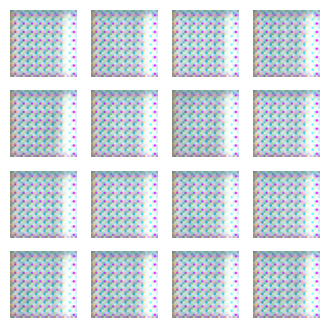

In [55]:
def generate_and_save_images(model, epoch, test_input):
    # Import matplotlib.pyplot
    import matplotlib.pyplot as plt

    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)  # Normalizasyonu geri al
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

# Rastgele gürültü ile görüntü üretme
noise = tf.random.normal([16, noise_dim])
generate_and_save_images(generator, EPOCHS, noise)

In [61]:
# Veri kümesini batch'lere ayırma
BATCH_SIZE = 32
# Instead of using tf.data.AUTOTUNE, provide a suitable buffer size
# This should be a positive integer, ideally smaller than the dataset size
# but large enough for effective shuffling.
# You can use len(images) if memory allows, otherwise choose a smaller value.
buffer_size = min(len(images), 1024)  # Example: using 1024 as buffer size
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(buffer_size=buffer_size).batch(BATCH_SIZE)

Epoch 1, Generator Loss: 0.9494276642799377, Discriminator Loss: 0.9862207174301147, Zaman: 24.677737951278687 s
Epoch 2, Generator Loss: 1.1010143756866455, Discriminator Loss: 0.885012686252594, Zaman: 21.223828315734863 s
Epoch 3, Generator Loss: 1.028630018234253, Discriminator Loss: 0.9122582077980042, Zaman: 21.21371579170227 s
Epoch 4, Generator Loss: 1.1433528661727905, Discriminator Loss: 0.8424569368362427, Zaman: 22.439871311187744 s
Epoch 5, Generator Loss: 1.0152596235275269, Discriminator Loss: 0.9718248248100281, Zaman: 20.31437611579895 s
Epoch 6, Generator Loss: 1.331364393234253, Discriminator Loss: 0.6701492667198181, Zaman: 21.693355798721313 s
Epoch 7, Generator Loss: 1.0019335746765137, Discriminator Loss: 0.84550940990448, Zaman: 20.99779176712036 s
Epoch 8, Generator Loss: 1.273574948310852, Discriminator Loss: 0.6822130680084229, Zaman: 22.49611735343933 s
Epoch 9, Generator Loss: 1.1448900699615479, Discriminator Loss: 0.8844560384750366, Zaman: 22.33797144889

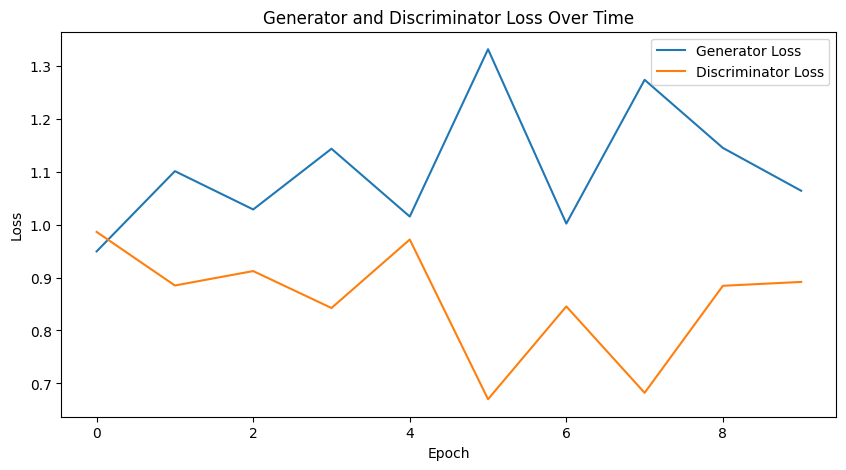

In [65]:
# Kayıpları kaydetmek için listeler
gen_losses = []
disc_losses = []

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        epoch_gen_loss = []
        epoch_disc_loss = []

        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

        # Epoch kayıplarını kaydet
        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))

        print(f'Epoch {epoch + 1}, Generator Loss: {gen_losses[-1]}, Discriminator Loss: {disc_losses[-1]}, Zaman: {time.time() - start} s')

# Eğitimi başlat
train(dataset, EPOCHS)

# Kayıp grafiğini çizme
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss Over Time')
plt.legend()
plt.show()